# Metrics of classification probabilities

TODO: change double float probs to integers, for less space/volume of data, could precompute from binned probabilities, check that it can be done in sql

also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [1]:
%matplotlib inline
import sys
import os
import requests
import datetime
import dateutil.parser
import json
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics

In [2]:
 os.getenv("HOME")

'/home/aimalz'

In [3]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "aimalz"#"rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [4]:
rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [5]:
def run_query(query, subdict=None):
    if subdict == None:
        subdict = {}
    result = rqs.post( f'{url}/db/runsqlquery/',
        json={ 'query': query, 'subdict': subdict } )
    if result.status_code != 200:
        sys.stderr.write( f"ERROR: got status code {result.status_code} ({result.reason})\n" )
    else:
        data = json.loads( result.text )
        if ( 'status' not in data ) or ( data['status'] != 'ok' ):
            sys.stderr.write( "Got unexpected response\n" )
            print(data['error'])
        else:
            return data['rows']

In [6]:
rows = run_query( 'SELECT "classifierId","brokerName","brokerVersion",'
                  '"classifierName","classifierParams" '
                  'FROM elasticc_brokerclassifier' )
classifier_info = {}
for row in rows:
    classifier_info[row["classifierId"]] = row             
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

TODO: select just a couple classifiers/brokers

In [7]:
use_cfers = {i: classifier_info[i] for i in [40,44]}
use_cfers

{40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 44: {'classifierId': 44,
  'brokerName': 'ANTARES',
  'brokerVersion': '2.0.0',
  'classifierName': 'LiCuParsnip_filter',
  'classifierParams': 'v2'}}

In [8]:
rows = run_query( 'SELECT DISTINCT ON ("classId") "classId",description '
                  'FROM elasticc_gentypeofclassid '
                  'ORDER BY "classId"' )
classname = {}
for row in rows:
    classname[row["classId"]] = row["description"]

In [9]:
classname

{0: 'Static/Other',
 1: 'Non-Recurring',
 2: 'Recurring',
 10: 'Non-Recurring/Other',
 11: 'SN-like',
 12: 'Fast',
 13: 'Long',
 20: 'Recurring/Other',
 21: 'Periodic',
 22: 'Non-Periodic',
 110: 'SN-like/Other',
 111: 'Ia',
 112: 'Ib/c',
 113: 'II',
 114: 'Iax',
 115: '91bg',
 120: 'Fast/Other',
 121: 'KN',
 122: 'M-dwarf Flare',
 123: 'Dwarf Nova',
 124: 'uLens',
 130: 'Long/Other',
 131: 'SLSN',
 132: 'TDE',
 133: 'ILOT',
 134: 'CART',
 135: 'PISN',
 210: 'Periodic/Other',
 211: 'Cepheid',
 212: 'RR Lyrae',
 213: 'Delta Scuti',
 214: 'EB',
 215: 'LPV/Mira',
 220: 'Non-Periodic/Other',
 221: 'AGN'}

## Everything above here is setup.  Run all that.  Then pick and choose below.

In [10]:
# consider descIngestTimestamp, alertSentTimestamp
#
# alertSentTimestamp -- this gets updated in the database when the original
#    alert is sent out.  It's NOT present in the dev database, but should
#    be in the real one
# descIngestTimestamp -- just when we happend to suck in the broker message
#
# alertId -- opaque fingerprint, don't sort on it, but it does correspond to
#   the original alert.  Different alertId = different source, i.e.
#   measurement of the transient.

sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'ORDER BY "diaObjectId","descIngestTimestamp","classifierId" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data
# classifiers = data.classifierId.unique()

Query start at 2022-12-15T14:22:19.050217...
Query done at 2022-12-15T14:22:19.703027


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp
0,80,1000038,215,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
1,80,1000038,220,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
2,80,1000038,120,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
3,80,1000038,130,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
4,42,1000038,221,2000076121,113,5.594780e-02,2022-12-10T20:41:26.728Z
...,...,...,...,...,...,...,...
95,41,1000174,122,2000348000,113,6.963106e-27,2022-12-07T02:06:40.821Z
96,41,1000174,135,2000348000,113,3.072997e-16,2022-12-07T02:06:40.821Z
97,41,1000174,212,2000348000,113,1.763961e-16,2022-12-07T02:06:40.821Z
98,41,1000174,131,2000348000,113,8.077484e-12,2022-12-07T02:06:40.821Z


TODO: change double float probs to integers, for less space/volume of data
also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [12]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp","alertSentTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'WHERE "classifierId"=41 AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","descIngestTimestamp" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:22:19.783549...
Query done at 2022-12-15T14:22:20.530885


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
0,41,1003330,111,2006660055,111,2.405586e-01,2022-11-27T21:28:43.173Z,2022-11-27T20:52:51.483Z
1,41,1003330,111,2006660057,111,7.859872e-02,2022-11-28T20:49:37.834Z,2022-11-28T20:15:28.501Z
2,41,1003330,111,2006660058,111,5.613366e-02,2022-11-28T20:54:12.790Z,2022-11-28T20:16:30.063Z
3,41,1003330,111,2006660063,111,2.854418e-02,2022-11-29T20:32:59.080Z,2022-11-29T20:29:33.532Z
4,41,1003330,111,2006660066,111,3.136482e-01,2022-11-30T02:40:35.129Z,2022-11-30T01:52:34.897Z
...,...,...,...,...,...,...,...,...
95,41,1006052,111,2012104015,111,5.731732e-07,2022-11-07T02:57:52.919Z,2022-11-06T21:59:53.852Z
96,41,1006052,111,2012104016,111,1.798039e-06,2022-11-07T03:34:34.063Z,2022-11-06T22:07:05.791Z
97,41,1006052,111,2012104017,111,1.654458e-03,2022-11-07T03:42:50.384Z,2022-11-06T22:07:59.839Z
98,41,1006052,111,2012104018,111,3.065239e-03,2022-11-07T22:52:54.928Z,2022-11-07T20:39:26.731Z


In [13]:
import numpy as np
np.unique(data['diaObjectId'], return_counts=True)

(array([1003330, 1003377, 1003402, 1003722, 1003806, 1003878, 1004142,
        1004205, 1004461, 1004475, 1004497, 1004610, 1004688, 1004893,
        1004913, 1004931, 1004978, 1005358, 1005627, 1005628, 1005646,
        1005738, 1005787, 1005839, 1005956, 1006052]),
 array([ 6, 10,  2, 11,  3,  1,  4,  3,  2,  2,  8,  1,  2,  4,  2,  1,  5,
         1,  1,  2,  5,  3,  2,  1,  8, 10]))

In [14]:
chosen = 1006052#1003722

In [15]:
data[ data['diaObjectId'] == chosen]#1025381 ]

,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
90,41,1006052,111,2012104008,111,6.936774e-10,2022-11-05T11:11:38.956Z,2022-11-04T22:42:36.608Z
91,41,1006052,111,2012104009,111,1.581636e-06,2022-11-06T00:16:16.213Z,2022-11-05T20:58:15.526Z
92,41,1006052,111,2012104011,111,2.350404e-02,2022-11-06T22:08:14.723Z,2022-11-06T20:48:17.581Z
93,41,1006052,111,2012104012,111,2.235560e-04,2022-11-06T22:10:11.653Z,2022-11-06T20:48:41.619Z
94,41,1006052,111,2012104013,111,1.695165e-08,2022-11-07T01:08:33.449Z,2022-11-06T21:36:26.610Z
95,41,1006052,111,2012104015,111,5.731732e-07,2022-11-07T02:57:52.919Z,2022-11-06T21:59:53.852Z
96,41,1006052,111,2012104016,111,1.798039e-06,2022-11-07T03:34:34.063Z,2022-11-06T22:07:05.791Z
97,41,1006052,111,2012104017,111,1.654458e-03,2022-11-07T03:42:50.384Z,2022-11-06T22:07:59.839Z
98,41,1006052,111,2012104018,111,3.065239e-03,2022-11-07T22:52:54.928Z,2022-11-07T20:39:26.731Z
99,41,1006052,111,2012104019,111,5.692855e-04,2022-11-07T22:58:29.966Z,2022-11-07T20:40:02.672Z


In [16]:
# All these joins suggest we need a new view.
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai" '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'WHERE v."diaObjectId"='+str(chosen)+' AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:22:20.658597...
Query done at 2022-12-15T14:22:21.030127


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,alertSentTimestamp,midPointTai
0,40,1006052,111,2012104008,111,0.100034,2022-11-04T22:42:36.608Z,60611.3669
1,40,1006052,111,2012104009,111,0.046289,2022-11-05T20:58:15.526Z,60612.3552
2,40,1006052,111,2012104011,111,0.064897,2022-11-06T20:48:17.581Z,60626.3207
3,40,1006052,111,2012104012,111,0.115420,2022-11-06T20:48:41.619Z,60626.3326
4,40,1006052,111,2012104013,111,0.233964,2022-11-06T21:36:26.610Z,60632.3355
...,...,...,...,...,...,...,...,...
136,83,1006052,111,2012104025,111,0.038187,2022-11-07T23:01:45.661Z,60646.2967
137,83,1006052,111,2012104026,111,0.038102,2022-11-07T23:12:11.685Z,60647.3075
138,83,1006052,111,2012104027,111,0.029178,2022-11-07T23:12:33.636Z,60647.3187
139,83,1006052,111,2012104039,111,0.997230,2022-11-09T21:20:40.833Z,60667.2721


In [17]:
pandas.set_option('display.max_rows', 500)
data['t'] = data['alertSentTimestamp'].apply( lambda thing : dateutil.parser.isoparse( thing ) )
data.columns


Index(['classifierId', 'diaObjectId', 'classId', 'alertId', 'trueClassId',
       'probability', 'alertSentTimestamp', 'midPointTai', 't'],
      dtype='object')

In [18]:
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

In [20]:
# for i,cfer in enumerate(classifiers):
#     print(cfer,classifier_info[cfer]["brokerName"],classifier_info[cfer]["classifierName"],classifier_info[cfer]["brokerVersion"])

In [21]:
blind = False

/tmp/ipykernel_1190303/328870598.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


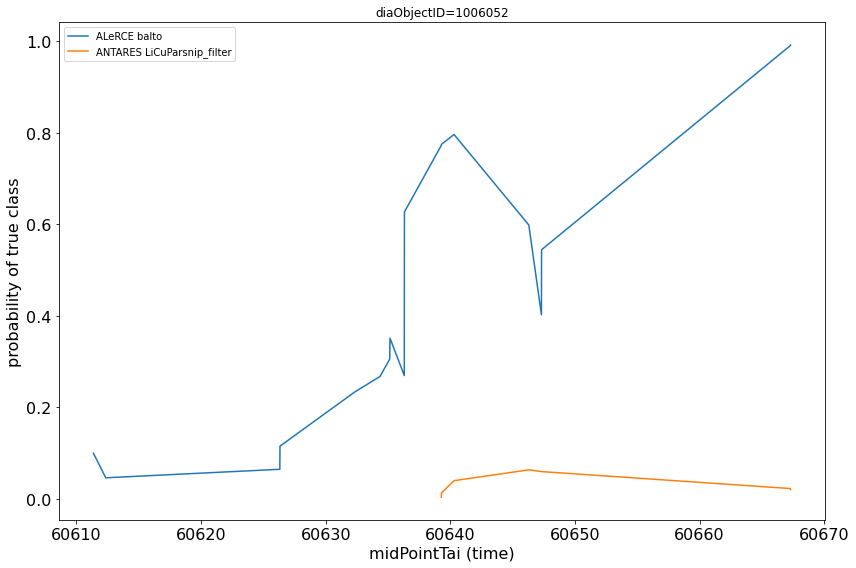

In [22]:
    
# TODO: color for broker, linestyle for classifier

fig = plt.figure( figsize=(12,8), tight_layout=True )
ax = fig.add_subplot( 1,1,1)
classifiers = data['classifierId'].unique()
for i,cfer in enumerate(use_cfers):
    subdata = data[ data['classifierId'] == cfer ]
    label = f'{use_cfers[cfer]["brokerName"]} {use_cfers[cfer]["classifierName"]}'
    ax.plot( subdata['midPointTai'], subdata['probability'], color=f'C{i}', label=label )
    ax.tick_params( "both", labelsize=16 )
if ~blind:
    ax.legend()
    ax.set_title('diaObjectID='+str(chosen))#"Jackson Pollock" )
ax.set_xlabel('midPointTai (time)', fontsize=16)
ax.set_ylabel('probability of true class', fontsize=16)
fig.show()

1. metric as f(time relative to characteristic time)
2. metric as f(number of alerts)



In [23]:
# Oh, the humanity
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai",t.peakmjd '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'INNER JOIN elasticc_diaobjecttruth t ON v."diaObjectId"=t."diaObjectId" '
          'WHERE v."diaObjectId" IN '
          '  ( SELECT "diaObjectId" FROM elasticc_diaobjecttruth WHERE gentype IN '
          '     ( SELECT gentype FROM elasticc_gentypeofclassid WHERE "classId"=111 ) '
          '    LIMIT 100 ) '
          'AND "classId"=111 '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:23:21.185652...


KeyboardInterrupt: 

In [ ]:
data['Δt'] = data['midPointTai'] - data['peakmjd']
data

In [ ]:
onebroker = data[ data['classifierId'] == 40 ].copy()

In [ ]:
onebroker

In [ ]:
plt.hist( onebroker['Δt'] )

In [ ]:
# This is not the right way to bin.  We have to think harder about this.
# If there are more observations of some objectds, those objects will
# get overweighted.
onebroker['tbin'] = numpy.floor( ( onebroker['Δt'] + 20 ) / 5. )

In [ ]:
thing = onebroker.groupby( 'tbin' )['probability'].apply( 'mean' )

In [ ]:
plt.plot(thing)

In [ ]:
tuple(use_cfers.keys())

## New Query, Alex and Rob, 2022-12-15, Waiting For A Better Title

In [24]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai"-ot.peakmjd AS deltat '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'INNER JOIN elasticc_diaobjecttruth ot ON v."diaObjectId"=ot."diaObjectId" '
          'WHERE "classifierId" IN %(cfers)s AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","alertSentTimestamp" '
          'LIMIT 10000' )
rows = run_query( query, { 'cfers': tuple(use_cfers.keys()) } )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:25:00.053944...
Query done at 2022-12-15T14:25:03.342632


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,alertSentTimestamp,deltat
0,40,1000267,130,2000534000,111,0.000000,2022-12-04T22:34:16.368Z,-2.7723
1,40,1000267,120,2000534000,111,0.000000,2022-12-04T22:34:16.368Z,-2.7723
2,40,1000267,220,2000534000,111,0.000000,2022-12-04T22:34:16.368Z,-2.7723
3,40,1000267,215,2000534000,111,0.000000,2022-12-04T22:34:16.368Z,-2.7723
4,40,1000267,210,2000534000,111,0.000000,2022-12-04T22:34:16.368Z,-2.7723
...,...,...,...,...,...,...,...,...
9995,40,1008732,114,2017464032,111,0.000705,2022-10-07T02:41:38.848Z,0.4511
9996,40,1008732,113,2017464032,111,0.005752,2022-10-07T02:41:38.848Z,0.4511
9997,40,1008732,110,2017464032,111,0.005850,2022-10-07T02:41:38.848Z,0.4511
9998,40,1008732,132,2017464032,111,0.000019,2022-10-07T02:41:38.848Z,0.4511


In [55]:
pre_probvecs = data.groupby(['alertId', "classifierId"])
probvecs = data.set_index(['alertId', "classifierId", "classId"])
# for idno in data['classId'].unique():
#     probvecs[str(idno)] = data['classId'=]
probvecs

diaObjectId  trueClassId  probability  \
alertId    classifierId classId                                          
2000534000 40           130          1000267          111     0.000000   
                        120          1000267          111     0.000000   
                        220          1000267          111     0.000000   
                        215          1000267          111     0.000000   
                        210          1000267          111     0.000000   
...                                      ...          ...          ...   
2017464032 40           114          1008732          111     0.000705   
                        113          1008732          111     0.005752   
                        110          1008732          111     0.005850   
                        132          1008732          111     0.000019   
                        124          1008732          111     0.000003   

                                       alertSentTimestamp  deltat  bin_prob  
alertId    classifierId classId                                              
2000534000 40           130      2022-12-04T22:34:16.368Z -2.7723      0.00  
                        120      2022-12-04T22:34:16.368Z -2.7723      0.00  
                        220      2022-12-04T22:34:16.368Z -2.7723      0.00  
                        215      2022-12-04T22:34:16.368Z -2.7723      0.00  
                        210      2022-12-04T22:34:16.368Z -2.7723      0.00  
...                                                   ...     ...       ...  
2017464032 40           114      2022-10-07T02:41:38.848Z  0.4511      0.00  
                        113      2022-10-07T02:41:38.848Z  0.4511      0.01  
                        110      2022-10-07T02:41:38.848Z  0.4511      0.01  
                        132      2022-10-07T02:41:38.848Z  0.4511      0.00  
                        124      2022-10-07T02:41:38.848Z  0.4511      0.00  

[10000 rows x 6 columns]

In [60]:
probvecs.index.levels[0]

Int64Index([2000534000, 2000534003, 2000534004, 2000534005, 2000534006,
            2000534007, 2000534008, 2000584063, 2000632039, 2000632041,
            ...
            2017158003, 2017158004, 2017158005, 2017158006, 2017158007,
            2017158015, 2017158024, 2017464026, 2017464027, 2017464032],
           dtype='int64', name='alertId', length=316)

In [ ]:
for alertids in probvecs.index.levels[0]:
    for classifierids in [40]:#probvecs.index.levels[1]:
        
plt.matshow(probvecs)

In [25]:
data['diaObjectId'].unique()

array([1000267, 1000292, 1000316, 1000448, 1000674, 1000757, 1000776,
       1001197, 1001216, 1001372, 1001409, 1001747, 1002071, 1002288,
       1002647, 1002657, 1002842, 1002970, 1003312, 1003330, 1003377,
       1003402, 1003722, 1003806, 1003878, 1004142, 1004205, 1004280,
       1004461, 1004475, 1004497, 1004610, 1004688, 1004713, 1004893,
       1004913, 1004931, 1004978, 1005358, 1005627, 1005628, 1005646,
       1005738, 1005787, 1005839, 1005956, 1006052, 1006147, 1006335,
       1006434, 1006466, 1006592, 1006701, 1007021, 1007116, 1007230,
       1007364, 1007486, 1007857, 1007858, 1007987, 1008033, 1008462,
       1008473, 1008505, 1008579, 1008732])

(array([3191., 2453., 1287.,    0.,    0.,    0.,    0.,    0.,    0.,
        3069.]),
 array([110. , 121.1, 132.2, 143.3, 154.4, 165.5, 176.6, 187.7, 198.8,
        209.9, 221. ]),
 <BarContainer object of 10 artists>)

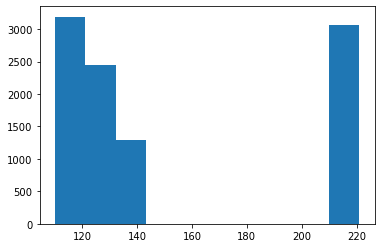

In [53]:
plt.hist(data['classId'])

In [44]:
data["bin_prob"] = data['probability'].round(decimals=2)

voila they sum to 1!

In [51]:
data.groupby(['alertId', "classifierId"])["probability"].sum()

alertId     classifierId
2000534000  40              1.0
2000534003  40              1.0
2000534004  40              1.0
2000534005  40              1.0
2000534006  40              1.0
2000534007  40              1.0
2000534008  40              1.0
2000584063  40              1.0
            44              1.0
2000632039  40              1.0
2000632041  40              1.0
            44              1.0
2000632044  40              1.0
2000896004  40              1.0
            44              1.0
2000896012  40              1.0
            44              1.0
2000896015  40              1.0
            44              1.0
2000896016  40              1.0
            44              1.0
2000896017  40              1.0
            44              1.0
2000896018  44              1.0
2000896019  40              1.0
2000896020  40              1.0
2000896021  40              1.0
2001348001  40              1.0
            44              1.0
2001348004  40              1.0
            44 